In [1]:
import lightgbm as lgb
import shap
import pickle
import json

model = pickle.load(open('2021-01-06_11:06:47_2e5c973a-5039-11eb-b2ec-557c888421ed/model.pkl','rb'))[0]
metadata = json.load(open('2021-01-06_11:06:47_2e5c973a-5039-11eb-b2ec-557c888421ed/metadata.json','r'))
feature_used = metadata['feature_names']
len(feature_used),metadata['dev_df_hash'],metadata['dev_jar_hash'],metadata['dev_fe_hash']

(336,
 '0x246c1ac1895140b3',
 '32fc21573a1a23df70d0aef0f4d588d7',
 'bccad645deb97e4d63f80cc992e75951')

In [2]:
dev_extracted = pickle.load(open(f'dev_0x246c1ac1895140b3_32fc21573a1a23df70d0aef0f4d588d7_bccad645deb97e4d63f80cc992e75951.pickle', 'rb'))
X = dev_extracted['data'].loc[:, feature_used].sample(frac=0.1, random_state=12345)

In [3]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

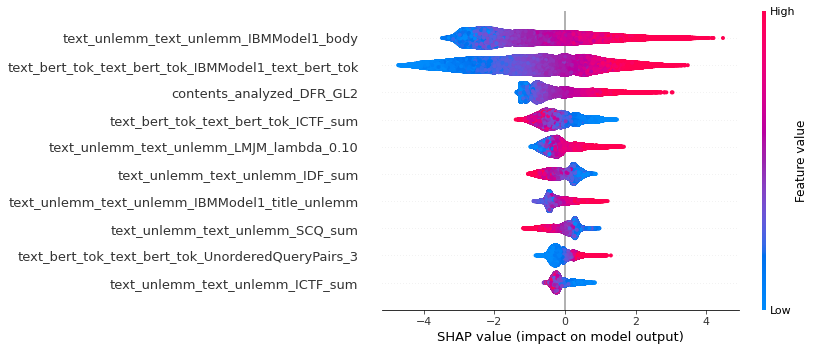

In [4]:
shap.summary_plot(shap_values, X, max_display=10)

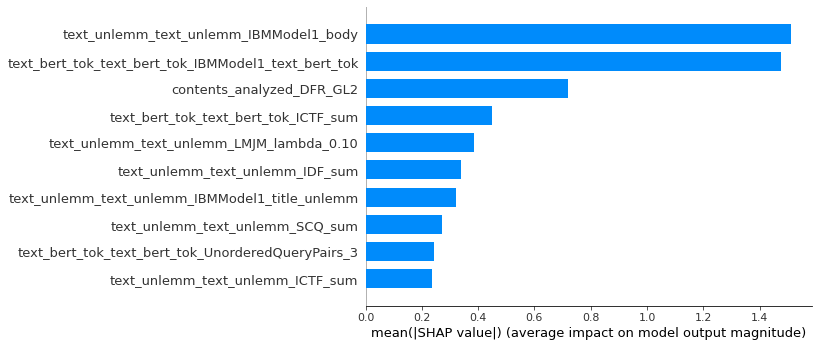

In [5]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

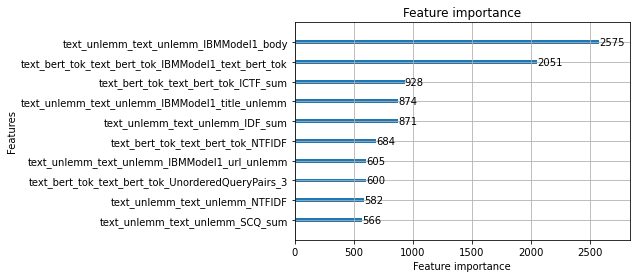

In [6]:
lgb.plot_importance(model, max_num_features=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

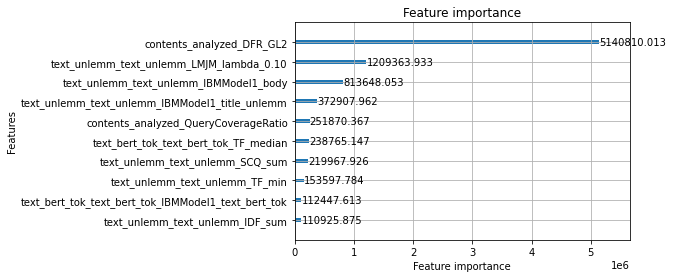

In [7]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')

In [80]:
import numpy as np
fi = np.sum(np.abs(shap_values), axis=0)
fi = fi / fi.sum()
fidx = np.argsort(fi)[::-1]
print('\n'.join(['%s %.2f percent'%(feature_used[idx], fi[idx]*100) for idx in fidx.tolist()[:10]]))

text_unlemm_text_unlemm_IBMModel1_body 14.48 percent
text_bert_tok_text_bert_tok_IBMModel1_text_bert_tok 14.14 percent
contents_analyzed_DFR_GL2 6.88 percent
text_bert_tok_text_bert_tok_ICTF_sum 4.32 percent
text_unlemm_text_unlemm_LMJM_lambda_0.10 3.69 percent
text_unlemm_text_unlemm_IDF_sum 3.23 percent
text_unlemm_text_unlemm_IBMModel1_title_unlemm 3.08 percent
text_unlemm_text_unlemm_SCQ_sum 2.59 percent
text_bert_tok_text_bert_tok_UnorderedQueryPairs_3 2.33 percent
text_unlemm_text_unlemm_ICTF_sum 2.25 percent


In [81]:
import numpy as np
fi = model.feature_importance(importance_type='gain')
fi = fi / fi.sum()
fidx = np.argsort(fi)[::-1]
print('\n'.join(['%s %.2f percent'%(feature_used[idx], fi[idx]*100) for idx in fidx.tolist()[:10]]))

contents_analyzed_DFR_GL2 47.62 percent
text_unlemm_text_unlemm_LMJM_lambda_0.10 11.20 percent
text_unlemm_text_unlemm_IBMModel1_body 7.54 percent
text_unlemm_text_unlemm_IBMModel1_title_unlemm 3.45 percent
contents_analyzed_QueryCoverageRatio 2.33 percent
text_bert_tok_text_bert_tok_TF_median 2.21 percent
text_unlemm_text_unlemm_SCQ_sum 2.04 percent
text_unlemm_text_unlemm_TF_min 1.42 percent
text_bert_tok_text_bert_tok_IBMModel1_text_bert_tok 1.04 percent
text_unlemm_text_unlemm_IDF_sum 1.03 percent


In [82]:
import numpy as np
fi = model.feature_importance(importance_type='split')
fi = fi / fi.sum()
fidx = np.argsort(fi)[::-1]
print('\n'.join(['%s %.2f percent'%(feature_used[idx], fi[idx]*100) for idx in fidx.tolist()[:10]]))

text_unlemm_text_unlemm_IBMModel1_body 4.19 percent
text_bert_tok_text_bert_tok_IBMModel1_text_bert_tok 3.34 percent
text_bert_tok_text_bert_tok_ICTF_sum 1.51 percent
text_unlemm_text_unlemm_IBMModel1_title_unlemm 1.42 percent
text_unlemm_text_unlemm_IDF_sum 1.42 percent
text_bert_tok_text_bert_tok_NTFIDF 1.11 percent
text_unlemm_text_unlemm_IBMModel1_url_unlemm 0.98 percent
text_bert_tok_text_bert_tok_UnorderedQueryPairs_3 0.98 percent
text_unlemm_text_unlemm_NTFIDF 0.95 percent
text_unlemm_text_unlemm_SCQ_sum 0.92 percent


In [101]:
import pandas as pd
fis = zip(feature_used,
       np.sum(np.abs(shap_values), axis=0),
       model.feature_importance(importance_type='split'),
       model.feature_importance(importance_type='gain'))
fis = pd.DataFrame(list(fis),columns=['fn','SHAP','split_num','split_gain']).set_index('fn')

In [102]:
fis['SHAP'] /= fis['SHAP'].sum()
fis['split_num'] /= fis['split_num'].sum()
fis['split_gain'] /= fis['split_gain'].sum()
fis['mean'] = fis['SHAP']*fis['split_gain']
fis.sort_values('mean',ascending=False).head(10)

,SHAP,split_num,split_gain,mean
fn,,,,
contents_analyzed_DFR_GL2,0.068804,0.005368,0.476201,0.032764
text_unlemm_text_unlemm_IBMModel1_body,0.144765,0.041884,0.075369,0.010911
text_unlemm_text_unlemm_LMJM_lambda_0.10,0.036901,0.006246,0.112025,0.004134
text_bert_tok_text_bert_tok_IBMModel1_text_bert_tok,0.141414,0.033361,0.010416,0.001473
text_unlemm_text_unlemm_IBMModel1_title_unlemm,0.030781,0.014216,0.034543,0.001063
text_unlemm_text_unlemm_SCQ_sum,0.025924,0.009206,0.020376,0.000528
text_bert_tok_text_bert_tok_TF_median,0.017944,0.002537,0.022117,0.000397
text_unlemm_text_unlemm_IDF_sum,0.032329,0.014167,0.010275,0.000332
text_bert_tok_text_bert_tok_UnorderedQueryPairs_3,0.023350,0.009759,0.008002,0.000187


<AxesSubplot:>

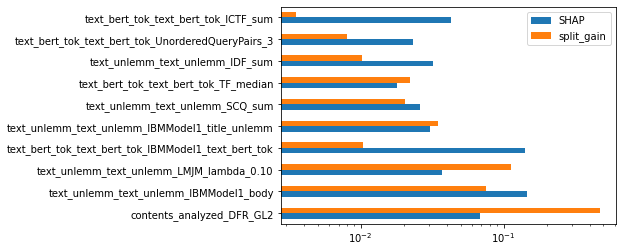

In [105]:
draw_df = fis.sort_values('mean',ascending=False).head(10).copy(deep=True)
del draw_df['mean']
del draw_df['split_num']
draw_df.plot.barh(logx=True,xlabel='')

In [145]:
import re
from collections import defaultdict
class_list = defaultdict(list)
def classify(fn):
    if re.search('DocSize',fn):
        if re.search('contents',fn):
            return 'analyzed'
        elif re.search('text_unlemm',fn):
            return 'text_unlemm'
        elif re.search('text_bert_tok',fn):
            return 'text_bert_tok'
        elif re.search('text',fn):
            return 'text'
    elif re.search('QueryCoverageRatio',fn):
        if re.search('analyzed',fn):
            return 'analyzed'
        elif re.search('text_unlemm',fn):
            return 'text_unlemm'
        elif re.search('text_bert_tok',fn):
            return 'text_bert_tok'
        elif re.search('text',fn):
            return 'text'
    elif re.search('contents',fn) or re.search('analyzed',fn):
        return 'analyzed'
    elif re.search('text_unlemm',fn):
        return 'text_unlemm'
    elif re.search('text_bert_tok',fn):
        return 'text_bert_tok'
    elif re.search('text',fn):
        return 'text'
    else:
        return 'others'
for fn in feature_used:
    class_list[classify(fn)].append(fn)
summary = {}
for f_class, fns in class_list.items():
    summary[f_class] = fis.loc[fns,:].sum()
summary = pd.DataFrame.from_dict(summary,orient='index')

<AxesSubplot:>

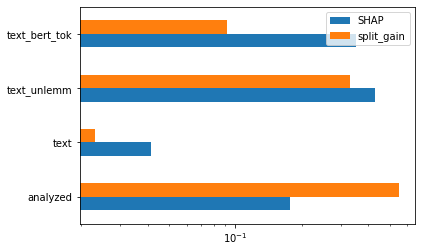

In [146]:
draw_df = summary.copy(deep=True)
del draw_df['mean']
del draw_df['split_num']
draw_df.plot.barh(logx=True,xlabel='')

In [186]:
import re
from collections import defaultdict
class_list = defaultdict(list)
def classify(fn):
    for group, plist in {
        'Translation Model': ['IBM'],
        'Proximity': ['Unordered','Ordered','TPscore','tpDist','Proximity'],
        'Relevance Model':['BM25','LMJM','LMD','DFR','DPH','NTFIDF','Prob','SCS'],
        'Stats':['max','min','median','avg','sum','var','confidence','maxminratio','Length','Term','Size','Coverage']
    }.items():
        for p in plist:
            if re.search(p, fn):
                return group
    print(fn)
    return 'others'
for fn in feature_used:
    class_list[classify(fn)].append(fn)
summary = {}
for f_class, fns in class_list.items():
    summary[f_class] = fis.loc[fns,:].sum()
summary = pd.DataFrame.from_dict(summary,orient='index')
summary

,SHAP,split_num,split_gain,mean
Relevance Model,0.241845,0.207973,0.649003,0.037237
Proximity,0.119088,0.137169,0.047516,0.000392
Stats,0.300636,0.555556,0.179006,0.001830
Translation Model,0.338431,0.099302,0.124475,0.013536


<AxesSubplot:>

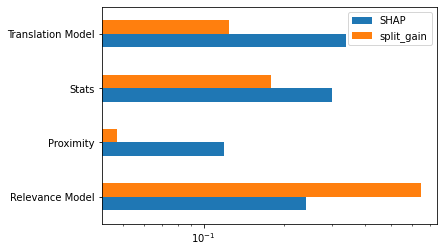

In [187]:
draw_df = summary.copy(deep=True)
del draw_df['mean']
del draw_df['split_num']
draw_df.plot.barh(logx=True,xlabel='')

In [185]:
list(filter(lambda x:re.search('Matching',x), feature_used))

['contents_analyzed_MatchingTermCount',
 'text_text_MatchingTermCount',
 'text_unlemm_text_unlemm_MatchingTermCount',
 'text_bert_tok_text_bert_tok_MatchingTermCount']